In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

# Preprocessing

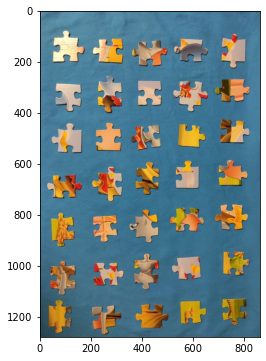

In [2]:
img = cv2.imread('dambo_blue_straight.jpg')
img = img[..., ::-1]
plt.figure(figsize = (8, 6))
plt.imshow(img)
img = cv2.GaussianBlur(img, (11, 11), 0)

## Remove background

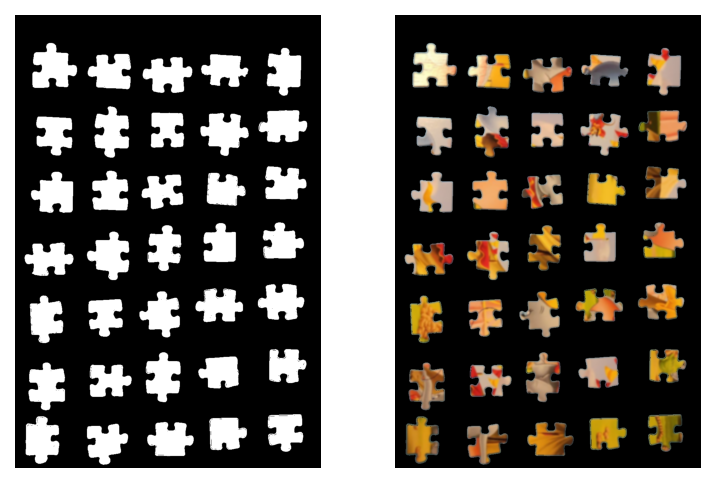

In [3]:
HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

background = np.median(HLS, axis=(0,1))
mask = np.mean(np.abs(HLS-background), axis=-1) < 30
img2 = img.copy()
img2[mask] = 0

plt.figure(dpi=150)
plt.subplot(1,2,1)   
plt.axis('off')
plt.imshow(1 - mask, cmap="gray")
plt.subplot(1,2,2)  
plt.axis('off')
plt.imshow(img2);

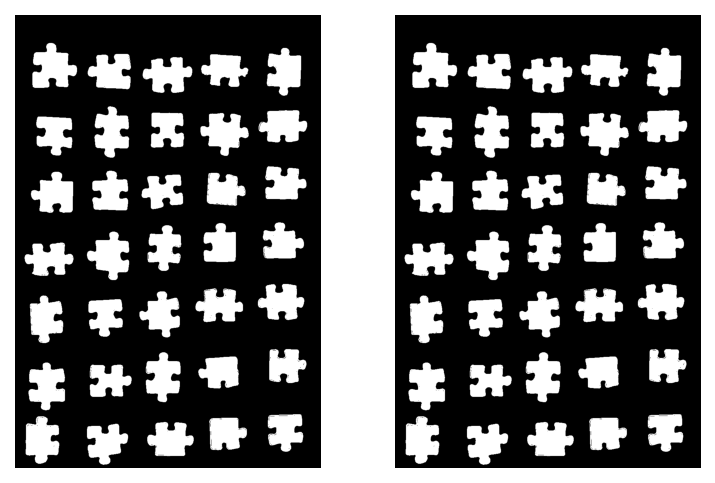

In [4]:
mask_int = mask.astype(np.uint8)
kernel = np.ones((1,1))
mask_int = cv2.morphologyEx(mask_int, cv2.MORPH_CLOSE, kernel)
kernel = np.ones((1,1))
mask_int = cv2.morphologyEx(mask_int, cv2.MORPH_OPEN, kernel)
img2 = img.copy()
img2[mask_int == 1] = 0


plt.figure(dpi=150)
plt.subplot(1,2,1)   
plt.axis('off')
plt.imshow(1 - mask, cmap="gray")
plt.subplot(1,2,2)  
plt.axis('off')
plt.imshow(1 - mask_int, cmap="gray");

## Drawing contours

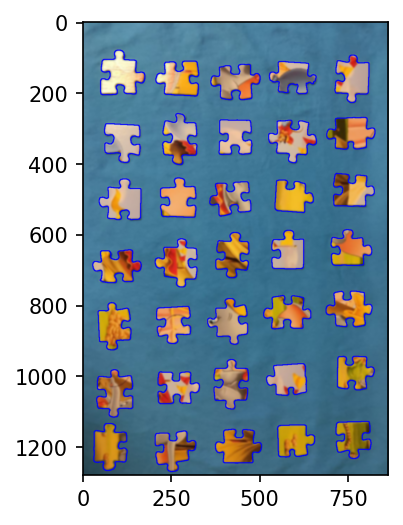

In [5]:
contours, hierarchy = cv2.findContours(1-mask_int, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
areas = []
for i in range(len(contours)):
    areas.append(cv2.contourArea(contours[i]))
cont_to_del = []            
for i in range(len(contours)):
    if areas[i] < 0.5 * max(areas):
        cont_to_del.append(i)
#     else:
#         cv2.drawContours(black, [contours[i]], 0, (255,255,255), 10)
contours = [contours[i] for i in range(len(contours)) if i not in cont_to_del]
        
img_cnt = img.copy()
cv2.drawContours(img_cnt, contours, -1, (0,0,255), 2)
plt.figure(dpi=150)
plt.imshow(img_cnt);

Посмотрим как фон будет отделяться на наших фотках

# Edge detection

## Corners

Let's extract puzzle pieces from the picture first.

In [6]:
def create_box(im, cnt):
    mins = np.min(cnt, axis=0)[0]
    maxs = np.max(cnt, axis=0)[0]
    top = max(maxs[1]+5 - (mins[1]-5), maxs[0]+5 - (mins[0]-5))
    tmp = im[max(0,int((mins[1] + maxs[1])/2 - top/2)) : int((mins[1] + maxs[1])/2 + top/2), max(0,int((mins[0] + maxs[0])/2 - top/2)) : int((mins[0] + maxs[0])/2 + top/2)]
    return tmp

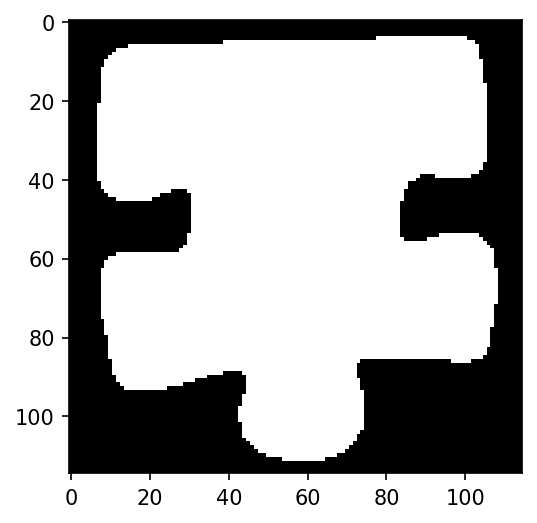

In [7]:
i = 4
black = np.zeros_like(img)
cv2.drawContours(black, [contours[i]], 0, (255,255,255), 2)
cv2.fillPoly(black, pts =[contours[i]], color=(255,255,255))
black = create_box(black, contours[i])
plt.figure(dpi=150)
plt.imshow(black, cmap='gray');

In [8]:
gray = cv2.cvtColor(black,cv2.COLOR_BGR2GRAY)
dst = cv2.cornerHarris(gray,10,5,0.04)
dst = cv2.dilate(dst,None)

Non maximum supression

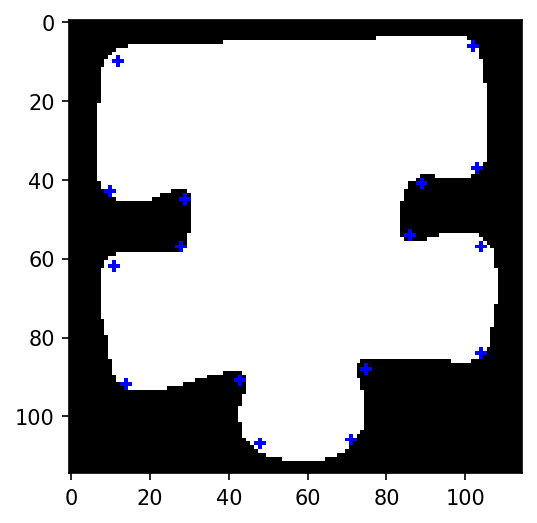

In [9]:
from skimage.measure import label
def get_local_centers(corr, th):
    lbl, n = label(corr >= th, connectivity=2, return_num=True)
    return np.int32([np.round(np.mean(np.argwhere(lbl == i), axis=0)) for i in range(1, n + 1)])


filtered_points = get_local_centers(dst, 0.15*dst.max())

blackk = black.copy()
for point in filtered_points:
    blackk[point[0]][point[1]]=[0,0,255]
    blackk[point[0]-1][point[1]]=[0,0,255]
    blackk[point[0]][point[1]-1]=[0,0,255]
    blackk[point[0]+1][point[1]]=[0,0,255]
    blackk[point[0]][point[1]+1]=[0,0,255]
plt.figure(dpi=150)
plt.imshow(blackk, cmap='gray');

In [10]:
import itertools
from scipy.stats import norm
fours = list(itertools.combinations(filtered_points, 4))

In [11]:
def order_points_2(pts):
    #pts is list !!
    pts[2], pts[3] = pts[3], pts[2]
    return pts

In [12]:
def order_points(pts):  # This function transforms 4 points of rectangle to the the same points in order
    # top-left, top-right, bottom-right, and bottom-left
    rect = np.zeros((4, 2), dtype="float32")
    pts = np.array(sorted(pts, key=lambda x: x[0]))
    top = pts[:2]
    btm = pts[2:]
    if top[0][1] > top[1][1]:
        tl, tr = top[1], top[0]
    else: 
        tl, tr = top[0], top[1]
        
    if btm[0][1] > btm[1][1]:
        bl, br = btm[1], btm[0]
    else:
        bl, br = btm[0], btm[1]

    return np.array([tl, tr, bl, br])

In [13]:
def compute_angles(dots):

    angles = np.zeros((4, 4))

    for i in range(4):
        for j in range(i + 1, 4):

            point_i, point_j = dots[i], dots[j]
            if point_i[0] == point_j[0]:
                angle = 90
            else:
                angle = np.arctan2(point_j[1] - point_i[1], point_j[0] - point_i[0]) * 180 / np.pi

            angles[i, j] = angle
            angles[j, i] = angle

    return angles

In [14]:
def find_rect_scores_2(dots):
    dots = list(dots)
    dots = order_points_2(dots)
    dots = np.array(dots)
    area = cv2.contourArea(dots)
    mse = 0
    da = []
    angles = compute_angles(dots)
    for i1, i2, i3 in [(0, 1, 2), (1, 2, 3), (2, 3, 0), (3, 0, 1)]:
        diff_angle = abs(angles[i1, i2] - angles[i2, i3])
        da.append(abs(diff_angle))
        mse += (diff_angle - 90) ** 2
    return [area, mse, np.mean(da)]

In [15]:
scores = [find_rect_scores_2(four) for j, four in enumerate(fours)]

In [16]:
scores_final = np.array(scores).T
scores_final = scores_final[0]*norm(0, 150).pdf(scores_final[1])

In [17]:
corner_points = list(fours[np.argmax(scores_final)])
corner_points = np.array(order_points_2(corner_points))

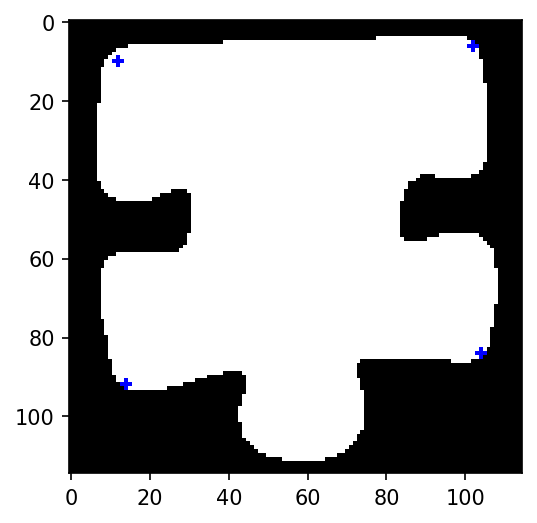

In [18]:
blackk = black.copy()
for point in corner_points:
    blackk[point[0]][point[1]]=[0,0,255]
    blackk[point[0]-1][point[1]]=[0,0,255]
    blackk[point[0]][point[1]-1]=[0,0,255]
    blackk[point[0]+1][point[1]]=[0,0,255]
    blackk[point[0]][point[1]+1]=[0,0,255]
plt.figure(dpi=150)
plt.imshow(blackk, cmap='gray');

## Lines

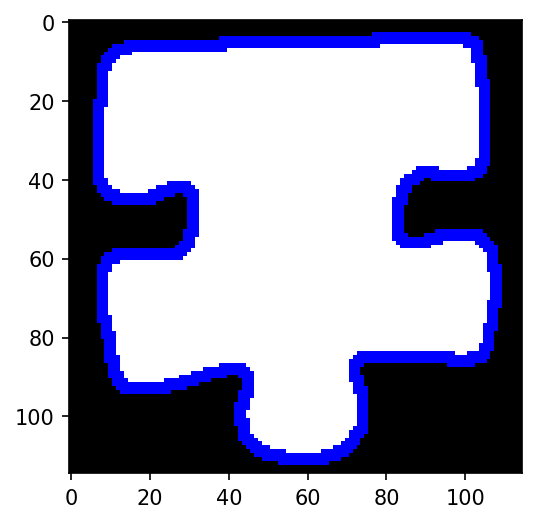

In [19]:
# Find contour of this piece (need new coordinates of contour points)
blackk = cv2.cvtColor(black,cv2.COLOR_BGR2GRAY) / blackk.max()
blackk = blackk.astype(np.uint8)
contours_piece, hierarchy = cv2.findContours(blackk, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
areas = []
for i in range(len(contours_piece)):
    areas.append(cv2.contourArea(contours_piece[i]))
cont_to_del = []            
for i in range(len(contours_piece)):
    if areas[i] < 0.5 * max(areas):
        cont_to_del.append(i)
contours_piece = [contours_piece[i] for i in range(len(contours_piece)) if i not in cont_to_del]
        
img_cnt = black.copy()
cv2.drawContours(img_cnt, contours_piece, -1, (0,0,255), 2)
plt.figure(dpi=150)
plt.imshow(img_cnt);

## New idea. Lets find the closest points to corners!

In [20]:
corner_points = list(fours[np.argmax(scores_final)])
corner_points = np.array(order_points_2(corner_points))

In [21]:
# Correct order of corner_points
def dist(p1, p2):
    return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)
dists = np.zeros(4)

def reorder_points(p):
    return [p[1], p[0]]

for i, point in enumerate(corner_points):
    corner_points[i] = reorder_points(point)
corner_points

array([[102,   6],
       [ 12,  10],
       [ 14,  92],
       [104,  84]], dtype=int32)

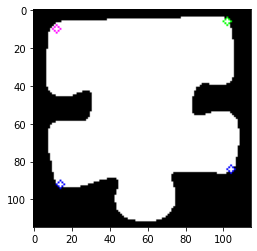

In [22]:
blackk = black.copy()
cv2.circle(blackk, tuple(corner_points[0]), 2, (0, 255, 0))
cv2.circle(blackk, tuple(corner_points[1]), 2, (255, 0, 255))
cv2.circle(blackk, tuple(corner_points[2]), 2, (0, 0, 255))
cv2.circle(blackk, tuple(corner_points[3]), 2, (0, 0, 255))
plt.imshow(blackk)

([array([12, 10], dtype=int32),
  array([14, 92], dtype=int32),
  array([104,  84], dtype=int32),
  array([102,   6], dtype=int32)],
 array([[[ 12,   7]],
 
        [[ 14,  93]],
 
        [[104,  85]],
 
        [[103,   6]]], dtype=int32))

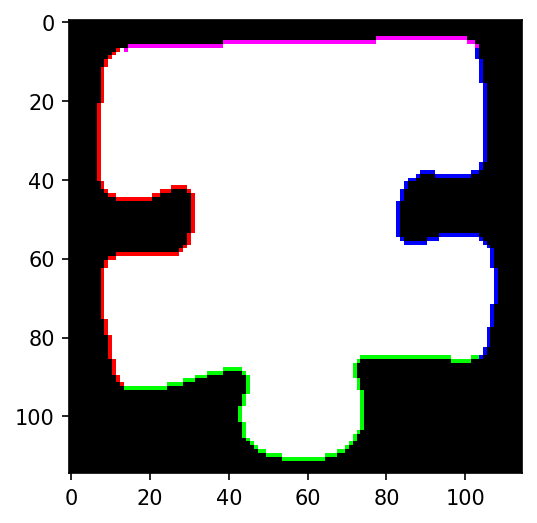

In [23]:
# Drawing edges with different colors
blackk = black.copy()
dists = np.zeros((4, len(contours_piece[0])))
for i in range(len(contours_piece[0])):
    for j in range(4):
        dists[j, i] = dist(contours_piece[0][i][0], corner_points[j])
closest_points_index = sorted(dists.argmin(axis = 1))

colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 0, 255)]
edges = [[] for i in range(4)]
for i in range(4):
    if i < 3:
        edges[i] = contours_piece[0][closest_points_index[i]:closest_points_index[i+1]+1]
        cv2.polylines(blackk, [edges[i]], False, colors[i])
    else:
        edges[i] = np.vstack([contours_piece[0][closest_points_index[i]:], contours_piece[0][:closest_points_index[0]]])
        cv2.polylines(blackk, [edges[i]], False, colors[i])
plt.figure(dpi=150)
plt.imshow(blackk)

corner_points = [corner_points[i] for i in np.argsort(dists.argmin(axis = 1))]
corner_points, contours_piece[0][closest_points_index]

# Classify edges

## Using mean of edge

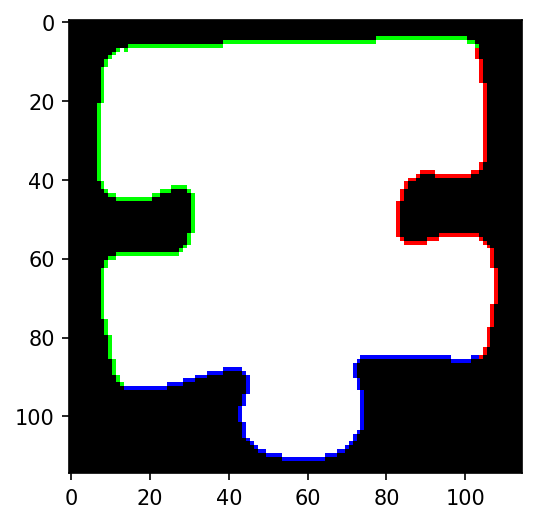

In [24]:
# green - flat
# red - in
# blue - out
blackk = black.copy()
for i in range(4):
    piece_center = contours_piece[0].mean(axis = 0)[0].astype(int)
    edge_center = edges[i].mean(axis = 0)[0].astype(int)
    [p1, p2] = [corner_points[i], corner_points[(i+1)%4]]

    sin_edge = np.cross(p2 - p1, edge_center - p1)/(np.linalg.norm(p2 - p1)*np.linalg.norm(edge_center - p1))
    sin_center = np.cross(p2 - p1, piece_center - p1)/(np.linalg.norm(p2 - p1)*np.linalg.norm(piece_center - p1))
    if np.abs(sin_edge) < 0.1:
        color = (0, 255, 0)
    elif sin_edge * sin_center < 0:
        color = (0, 0, 255)
    elif sin_edge * sin_center > 0:
        color = (255, 0, 0)
    cv2.polylines(blackk, [edges[i]], False, color)
plt.figure(dpi=150)
plt.imshow(blackk)

## Using max deviation of line - much better

In [25]:
lines = [[] for i in range(4)]
for i in range(4):
    lines[i] = [corner_points[i], corner_points[(i+1)%4]]

def dist_to_line(p1, p2, p3):
    # p1, p2 - points on a line
    return np.abs(np.cross(p2 - p1, p3 - p1)/(np.linalg.norm(p2 - p1)))

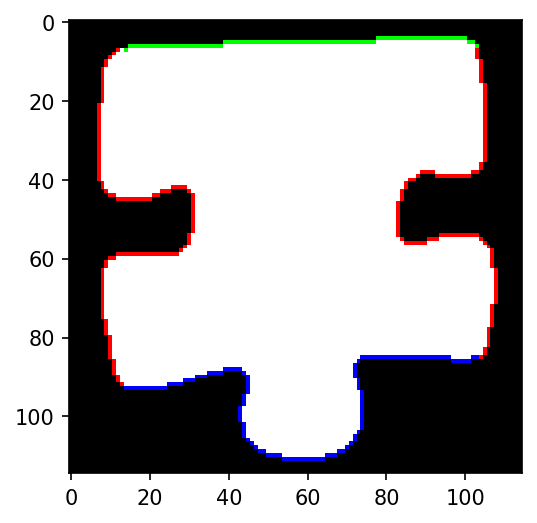

In [26]:
# green - flat
# red - in
# blue - out
blackk = black.copy()
for i in range(4):
    dists = np.zeros(len(edges[i]))
    for j in range(len(edges[i])):
        dists[j] = dist_to_line(lines[i][0], lines[i][1], edges[i][j])
    piece_center = contours_piece[0].mean(axis = 0)[0].astype(int)
    deviated_point = edges[i][dists.argmax()]
    [p1, p2] = [corner_points[i], corner_points[(i+1)%4]]

    sin_edge = np.cross(p2 - p1, deviated_point - p1)/(np.linalg.norm(p2 - p1)*np.linalg.norm(deviated_point - p1))
    sin_center = np.cross(p2 - p1, piece_center - p1)/(np.linalg.norm(p2 - p1)*np.linalg.norm(piece_center - p1))
    if dists.max() < 0.1 * dist(lines[i][0], lines[i][1]):
        color = (0, 255, 0)
    elif sin_edge * sin_center < 0:
        color = (0, 0, 255)
    elif sin_edge * sin_center > 0:
        color = (255, 0, 0)
    cv2.polylines(blackk, [edges[i]], False, color)
plt.figure(dpi=150)
plt.imshow(blackk);

## For drawing and debugging

(-0.02319561358607974, 0.014546817189861552)

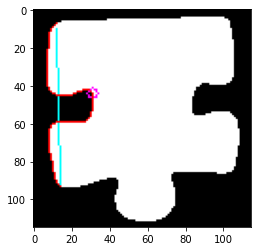

In [27]:
blackk = black.copy()
i = 0
dists = np.zeros(len(edges[i]))

for j in range(len(edges[i])):
        dists[j] = dist_to_line(lines[i][0], lines[i][1], edges[i][j])
        
piece_center = contours_piece[0].mean(axis = 0)[0].astype(int)
edge_center = edges[i].mean(axis = 0)[0].astype(int)
[p1, p2] = [corner_points[i], corner_points[(i+1)%4]]
# cv2.circle(blackk, tuple(piece_center), 3, (255, 0, 0))
# cv2.circle(blackk, tuple(edge_center), 3, (0, 255, 255))
cv2.circle(blackk, tuple(edges[i][dists.argmax()][0]), 3, (255, 0, 255))
# cv2.circle(blackk, tuple([25, 60]), 3, (0, 0, 255))

cv2.line(blackk, (p1[0], p1[1]), (p2[0], p2[1]), (255, 0, 255))
cv2.line(blackk, (lines[i][0][0], lines[i][0][1]), (lines[i][1][0], lines[i][1][1]), (0, 255, 255))

sin_edge = np.cross(p2 - p1, edge_center - p1)/(np.linalg.norm(p2 - p1)*np.linalg.norm(edge_center - p1))
sin_center = np.cross(p2 - p1, piece_center - p1)/(np.linalg.norm(p2 - p1)*np.linalg.norm(piece_center - p1))
if np.abs(sin_edge) < 0.01:
    color = (0, 255, 0)
elif sin_edge * sin_center < 0:
    color = (0, 0, 255)
elif sin_edge * sin_center > 0:
    color = (255, 0, 0)
cv2.polylines(blackk, [edges[i]], False, color)
plt.imshow(blackk)
sin_edge, sin_edge * sin_center